In [21]:
%matplotlib notebook

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import namedtuple

In [22]:
# Load the mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


<IPython.core.display.Javascript object>


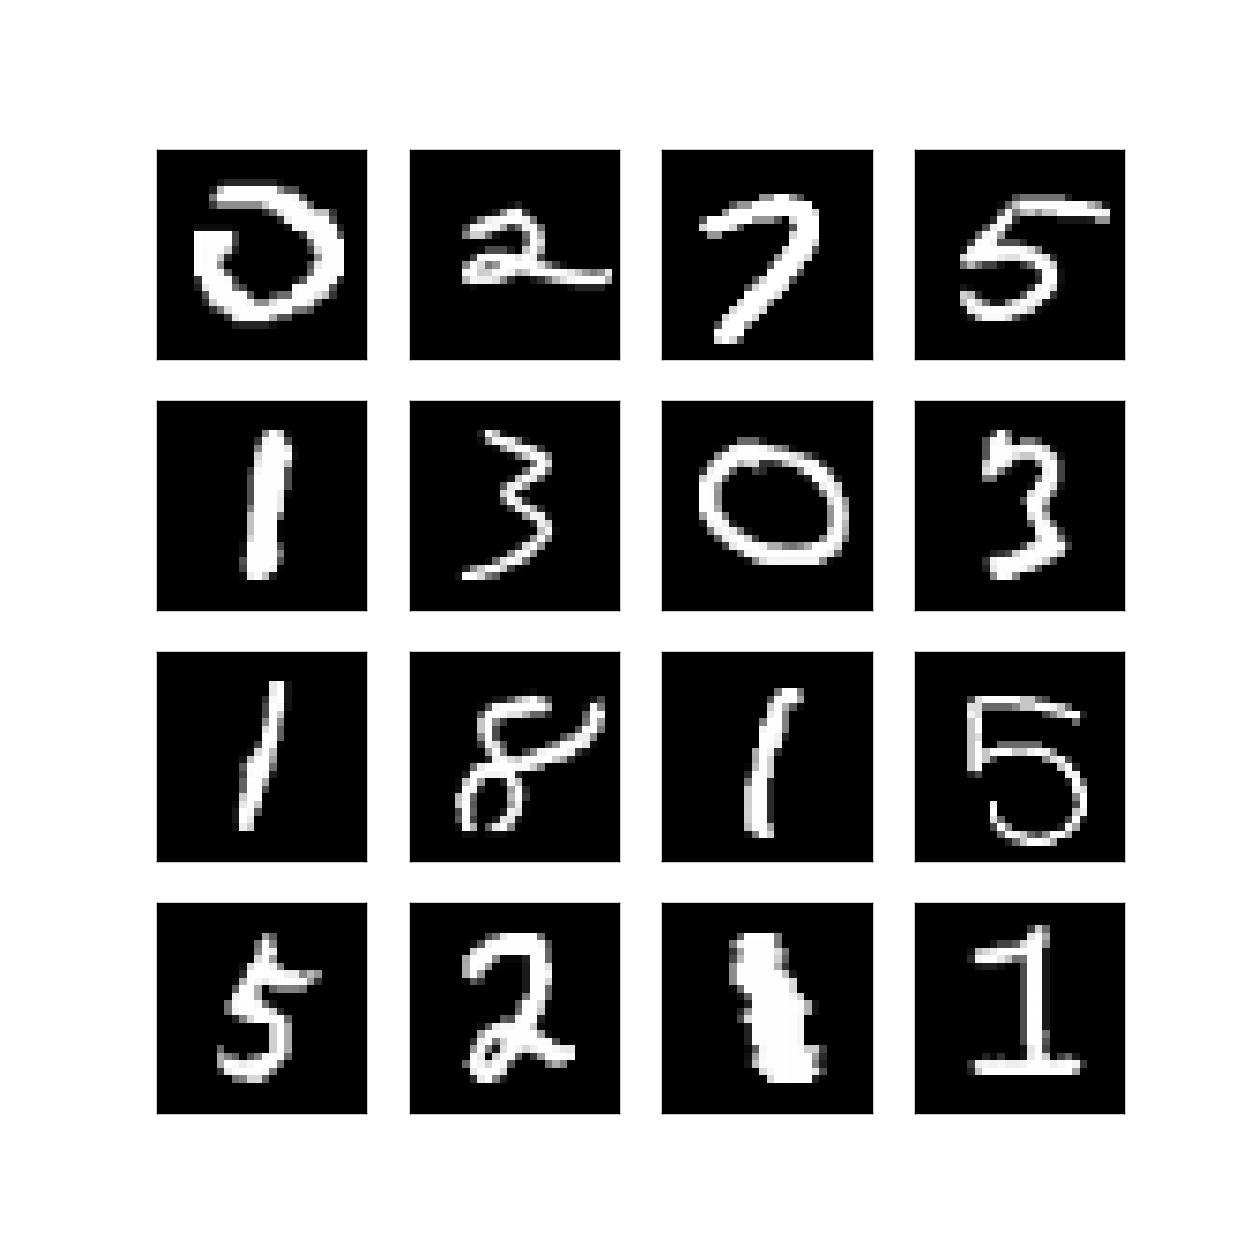

In [44]:
# Let us visualise the first 16 data points from the MNIST training data

fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(mnist.train.images[i].reshape(28, 28), cmap='Greys_r')  

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [5]:
Model = namedtuple('Model', 'x y_conv y_ keep_prob filt1_num filt1_size W_conv1 b_conv1 h_conv1 h_conv1_size')

def create_model(input_len, output_len, filt1_num, filt1_size, filt2_num, filt2_size):
    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_ = tf.reshape(x, [-1, 28, 28, 1])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])

    # Define the first convolution layer here
    W_conv1 = weight_variable([filt1_size, filt1_size, 1, filt1_num])
    b_conv1 = bias_variable([filt1_num])
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_, W_conv1, strides=[2, 2], padding='VALID') + b_conv1)

    # Define the second convolution layer here
    W_conv2 = weight_variable([filt2_size, filt2_size, filt1_num, filt2_num])
    b_conv2 = bias_variable([filt2_num])
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_conv1, W_conv2, strides=[1, 1], padding='SAME') + b_conv2)

    # Define maxpooling
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # All subsequent layers will be fully connected ignoring geometry so we'll flatten the layer
    # Flatten the h_pool2_layer (as it has a multidimensiona shape)
    flat_len = int(h_pool2.shape[1] * h_pool2.shape[2] * h_pool2.shape[3])
    h_pool2_flat = tf.reshape(h_pool2, [-1, flat_len])

    # Define the first fully connected layer here
    W_fc1 = weight_variable([flat_len, 1024])
    b_fc1 = bias_variable([1024])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Use dropout for this layer (should you wish)
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, rate=1-keep_prob)

    # The final fully connected layer
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    sess.run(tf.variables_initializer([W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2]))
    
    return Model(x, y_conv, y_, keep_prob, filt1_num, filt1_size, W_conv1, b_conv1, h_conv1, int(h_conv1.shape[1]))

In [6]:
Compilation = namedtuple('Compilation', 'train_step accuracy')

def compile_model(mod):
    # We'll use the cross entropy loss function 
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=mod.y_conv, labels=mod.y_))

    # And classification accuracy
    correct_prediction = tf.equal(tf.argmax(mod.y_conv, 1), tf.argmax(mod.y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # And the Adam optimiser
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train_step = optimizer.minimize(cross_entropy)
    
    sess.run(tf.variables_initializer(optimizer.variables()))
    
    return Compilation(train_step, accuracy)

In [7]:
# Start a tf session
sess = tf.Session()

In [8]:
# Run the optimisation algorithm

def train_model(mod, comp, iters):
    interval = iters // 10
    for i in range(iters):
        batch = mnist.train.next_batch(50)
        if i % interval == 0:
            train_accuracy = sess.run(comp.accuracy, feed_dict={mod.x: batch[0], mod.y_: batch[1], mod.keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        sess.run(comp.train_step, feed_dict={mod.x: batch[0], mod.y_: batch[1], mod.keep_prob: 0.5})

In [9]:
# Test a model

def test_model(mod, comp):
    acc = sess.run(comp.accuracy, feed_dict={mod.x: mnist.test.images, mod.y_: mnist.test.labels, mod.keep_prob: 1.0})
    print ('Test accuracy: %g' % acc)

In [10]:
# Visualise the filters in the first convolutional layer

def visualise_filters(mod):
    W = sess.run(mod.W_conv1)

    num = mod.filt1_num
    rows = int(num ** 0.5)
    cols = (mod.filt1_num - 1) // rows + 1
    fig = plt.figure()
    for i in range(num):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.imshow(W[:, :, 0, i], cmap='Greys_r')

In [11]:
# Visualise the activations of the first convolutional layer

def visualise_activations(mod, filt_num, top_num):
    H = sess.run(mod.h_conv1, feed_dict={mod.x: mnist.test.images})

    res_size = mod.h_conv1_size
    filt_size = mod.filt1_size
    fig = plt.figure()
    for i in range(filt_num):
        curr_H = H[:, :, :, i]
        top = np.argsort(curr_H, axis=None)
        for j in range(top_num):
            img_idx = top[j] // (res_size ** 2)
            x_coord = top[j] % (res_size ** 2) // res_size
            y_coord = top[j] % res_size
            show = mnist.train.images[img_idx].reshape(28, 28)[x_coord: x_coord + filt_size, y_coord: y_coord + filt_size]

            ax = fig.add_subplot(filt_num, top_num, i * top_num + j + 1)
            ax.set_xticks(())
            ax.set_yticks(())
            ax.imshow(show, cmap='Greys_r')

In [34]:
mod = create_model(784, 10, 25, 12, 64, 5)
comp = compile_model(mod)

In [35]:
train_model(mod, comp, 5000)

step 0, training accuracy 0.14
step 500, training accuracy 0.9
step 1000, training accuracy 0.98
step 1500, training accuracy 0.96
step 2000, training accuracy 1
step 2500, training accuracy 0.98
step 3000, training accuracy 1
step 3500, training accuracy 0.98
step 4000, training accuracy 1
step 4500, training accuracy 1


In [36]:
test_model(mod, comp)

Test accuracy: 0.9869


<IPython.core.display.Javascript object>


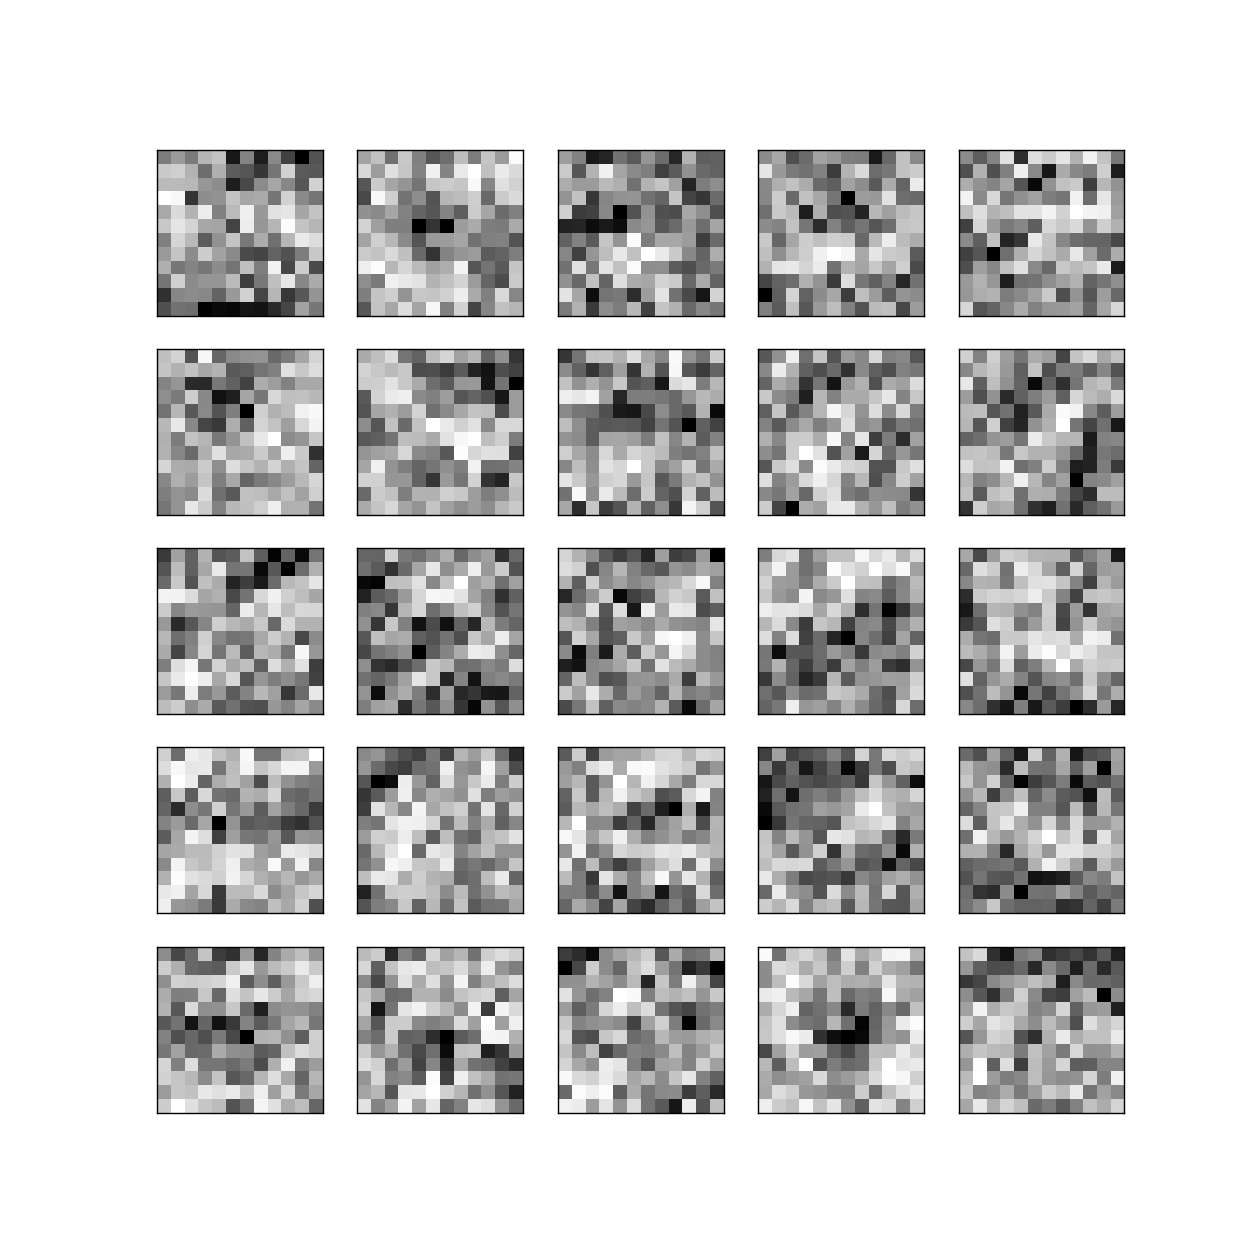

In [37]:
visualise_filters(mod)

<IPython.core.display.Javascript object>


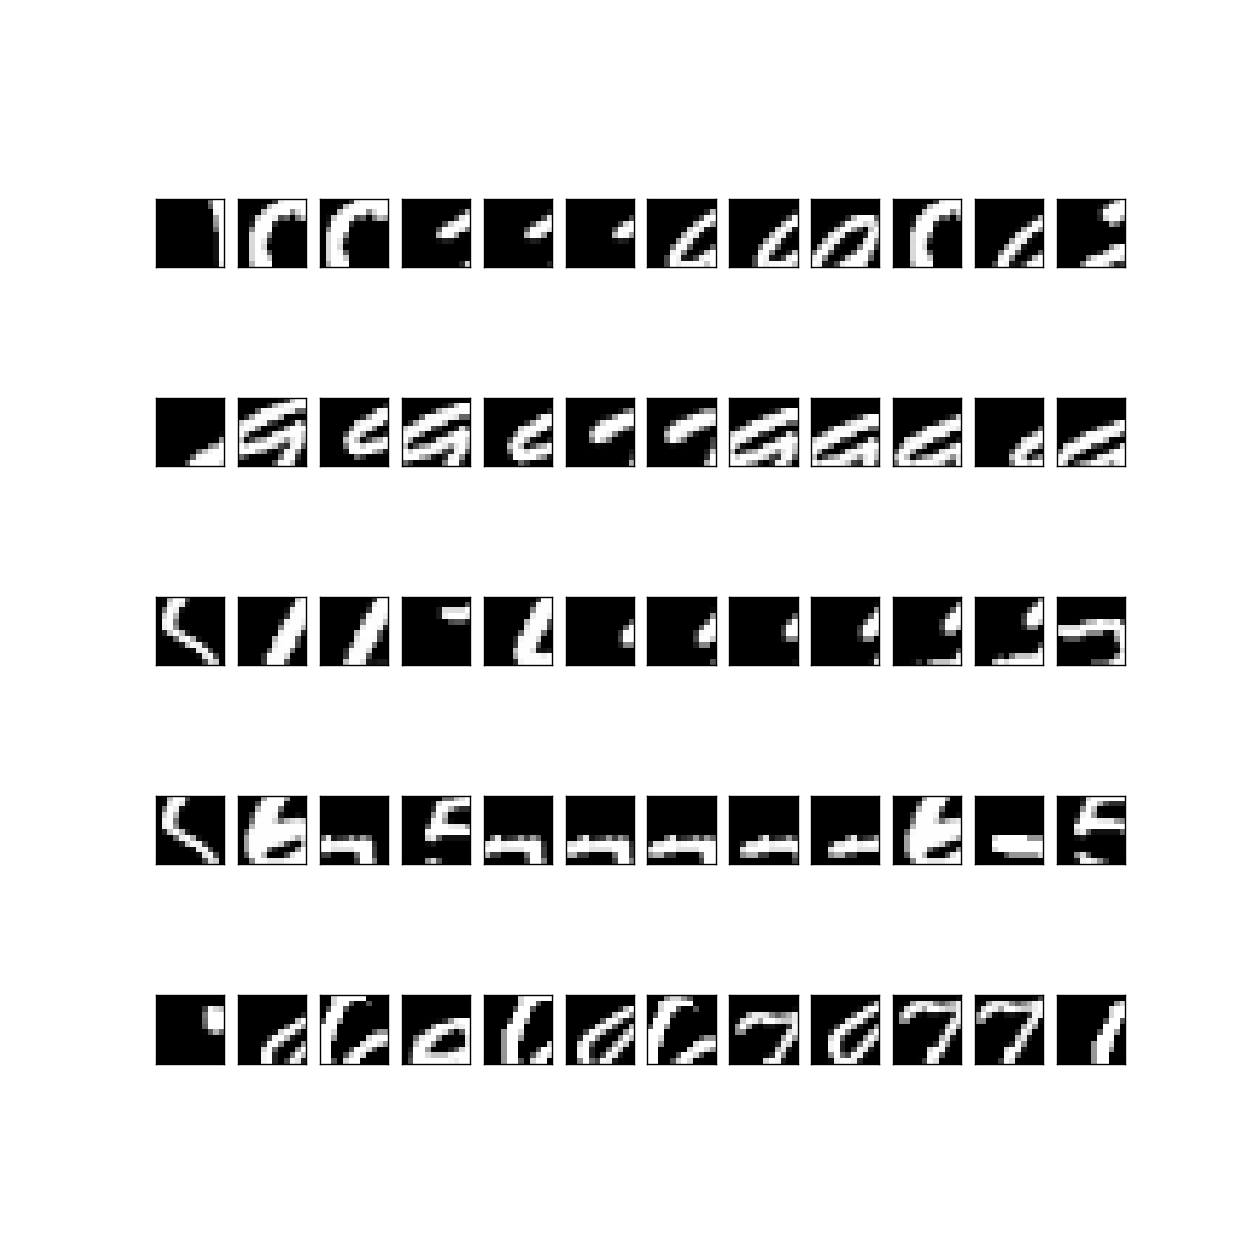

In [38]:
visualise_activations(mod, 5, 12)

In [39]:
mod2 = create_model(784, 10, 10, 5, 20, 5)
comp2 = compile_model(mod2)

In [40]:
train_model(mod2, comp2, 5000)

step 0, training accuracy 0.12
step 500, training accuracy 0.9
step 1000, training accuracy 0.96
step 1500, training accuracy 0.94
step 2000, training accuracy 0.9
step 2500, training accuracy 1
step 3000, training accuracy 0.9
step 3500, training accuracy 1
step 4000, training accuracy 1
step 4500, training accuracy 0.96


In [41]:
test_model(mod2, comp2)

Test accuracy: 0.9821


<IPython.core.display.Javascript object>


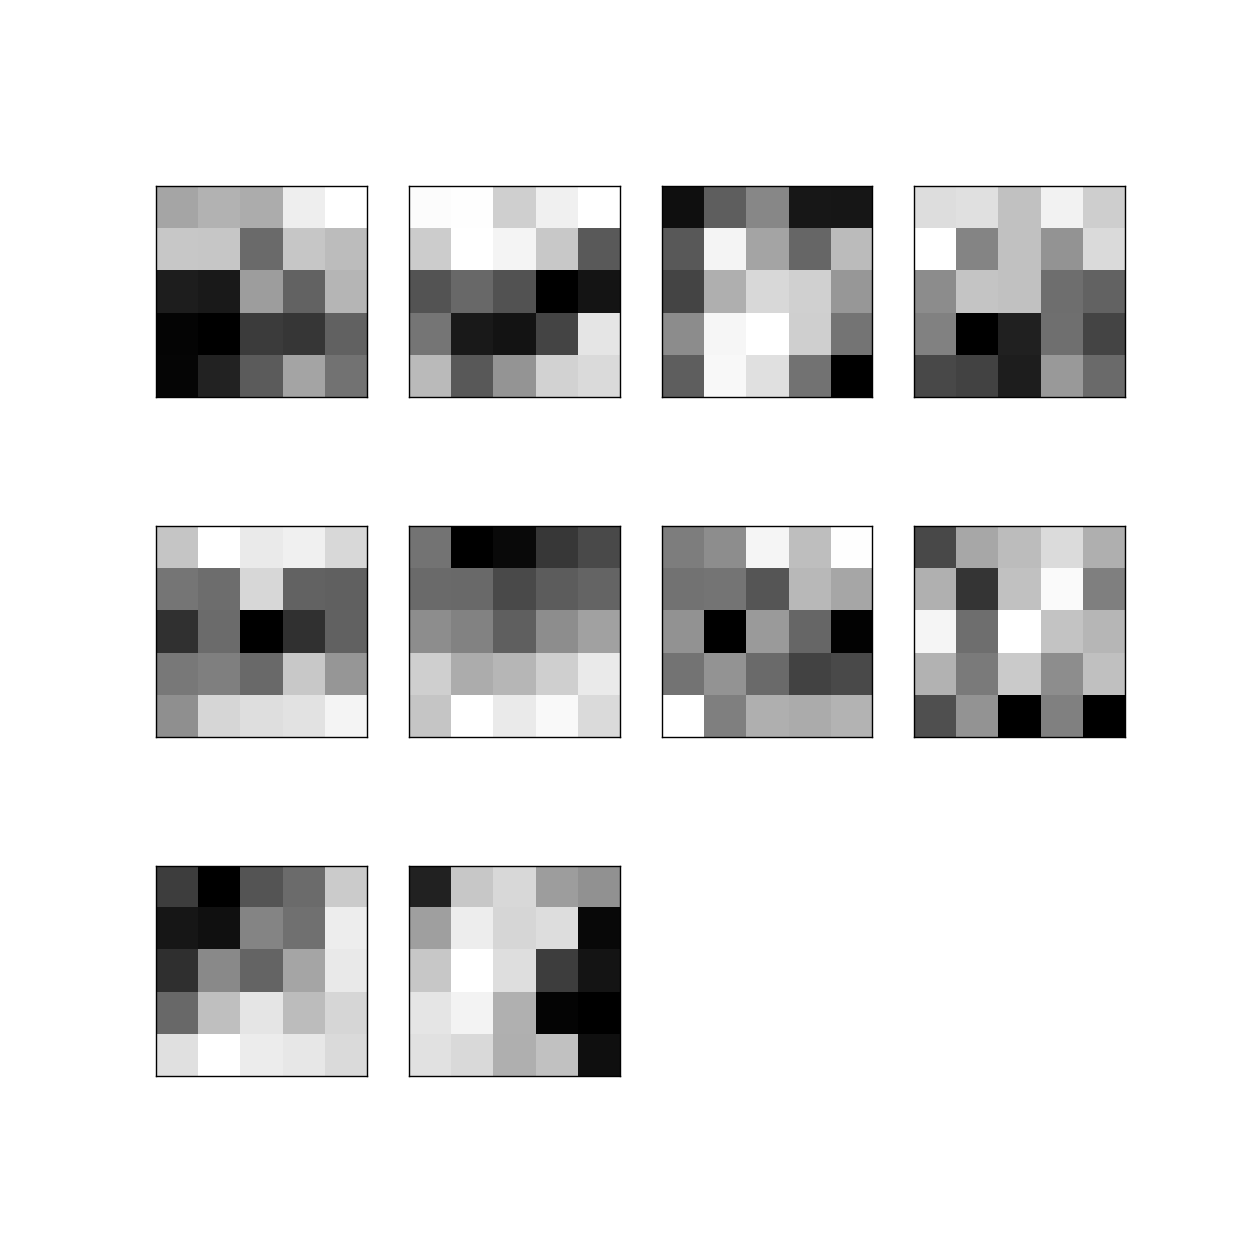

In [42]:
visualise_filters(mod2)

<IPython.core.display.Javascript object>


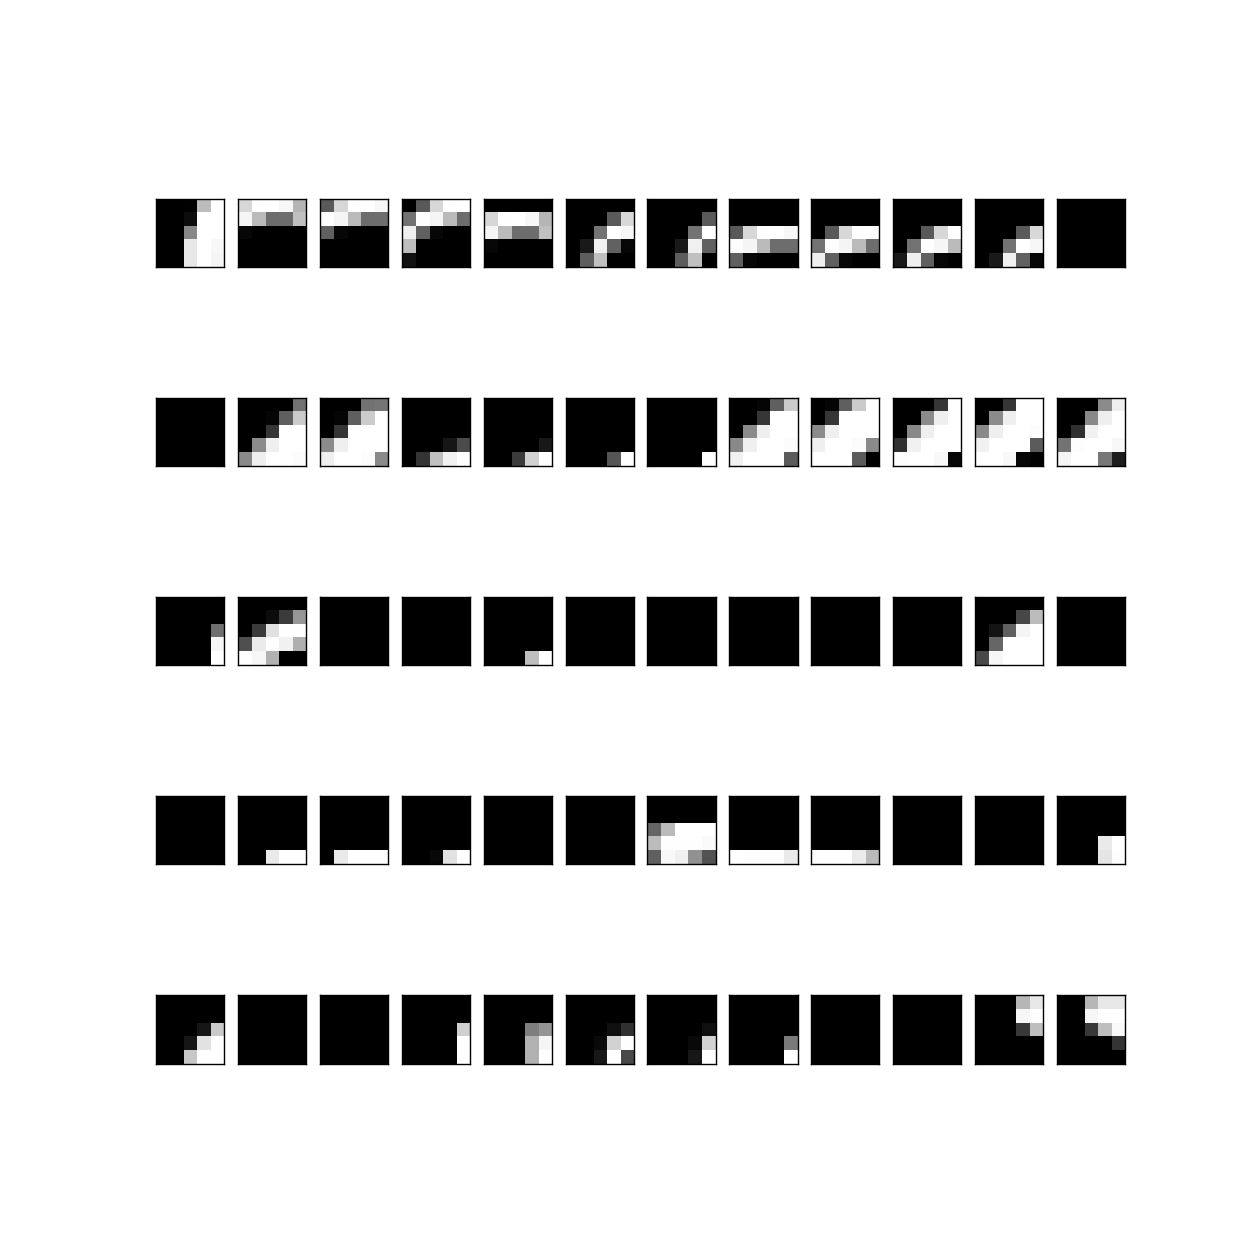

In [43]:
visualise_activations(mod2, 5, 12)